# Some mortality models with example

In this notebook, we present some common mortality models and we apply them to female french mortality data extracted from [HMD](https://mortality.org/).
It is inspired by the [StMoMo](https://www.rdocumentation.org/packages/StMoMo/versions/0.4.1) package in R.

## General form of the models

We suppose that the number of deaths at age `x` and time `t`, denoted $D_{xt}$ ($d_{xt}$ being an observation of $D_{xt}$), follow a Poisson distribution:

$$ D_{xt} \sim Poisson(E_{xt}\mu_{xt}),$$

where $E_{xt}$ is the central exposure at age `x` and time `t` and $\mu_{xt}$ is the force of mortality at age `x` and time `t`. We suppose that $x_{1} \leq x \leq x_{k}$ and $t_{1} \leq t \leq t_{n}$. 

All the models presented have a similar form, that is:

$$ log(\mu_{xt}) = \eta_{xt} = \alpha_{x} + \sum_{i=1}^{N}{\beta_{x}^{(i)}\kappa_{t}^{(i)}} + \beta_{x}^{(0)}\gamma_{t-x}, $$

where

+ $\alpha_{x}$ is a static **age** function.
+ $N$ is the number of **age-period** terms, with each $\kappa_{t}^{(i)}$ describing the mortality trend and each $\beta_{x}^{(i)}$ modulating its effect across ages. Each $\beta_{x}^{(i)}$ can be either a pre-specified function depending on x or non-parametric terms to estimate.
+ $\gamma_{t-x}$ is a **cohort** effect modulated across ages by the $\beta_{x}^{(0)}$ function, which is either a pre-specified function or non parametric-terms to estimate.

To ensure identifiability of a specific model, constraints can be imposed on the parameters.

The log-likelihood for such models can be written as:

$$ L = \sum_{x, t} \left[ {d_{xt} \left( \alpha_{x} + \sum_{i=1}^{N}{\beta_{x}^{(i)}\kappa_{t}^{(i)}} + \beta_{x}^{(0)}\gamma_{t-x} \right) - E_{xt}e^{ \left( \alpha_{x} + \sum_{i=1}^{N}{\beta_{x}^{(i)}\kappa_{t}^{(i)}} + \beta_{x}^{(0)}\gamma_{t-x} \right) }} \right] + constant.$$

The best parameters are those maximising the log-likelihood, and therefore setting its derivative to zero.

The search for such parameters is done through the **Newton-Raphson** algorithm, useful to find the zero of a function through 
an iterative procedure. 
Starting from a value $x_{0}$, we then rely on **Taylor expansion** to compute:

$$ x_{i+1} = x_{i} - \frac{f(x_{i})}{f'(x_{i})}.$$

In this notebook, we will focus on the **Lee-Carter** model, the **CBD model**, the **APC** model, and the **M6-M7-M8** models, each described in the following sections.

We will analyze the goodness of fit through 

1. Deviance residuals, defined as

$$ r_{xt} = sign(d_{xt}-\hat{d}_{xt})\sqrt{\frac{\text{dev}(x, t)}{\hat{\phi}}} \text{, }\quad \hat{\phi} = \frac{D(d_{xt}, \hat{d}_{xt})}{K-\nu},$$

with 

$$ \text{dev}(x, t) = 2 \left[ d_{xt}log \left( \frac{d_{xt}}{\hat{d}_{xt}} \right) - \left( d_{xt} - \hat{d}_{xt} \right) \right], $$

$$ D(d_{xt}, \hat{d}_{xt}) = \sum_{x, t}{\text{dev}(x, t)}, $$

and $K$ the number of observations in the data and $\nu$ the effective number of parameters in the model.

2. Classical quantities such as 

    + **MSE**: Mean Squared Error.
    + **MAE**: Mean Absolute Error.
    + **MAPE**: Mean Average Percentage Error.
    + **Explained variance**.
    + **$R^{2}$**.
    + **Deviance**.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Calibration parameters
age_min = 55
age_max = 89
t_min = 1950
t_max = 2019

In [4]:
# Age, period and cohort
x = range(age_min, age_max+1)
t = range(t_min, t_max+1)
g = range((t_min - age_max), (t_max - age_min)+1)

In [5]:
# Colors for plots
color_x = (30./255., 61./255., 89./255.)
color_t = (255./255., 193./255., 59./255.)
color_g = (255./255., 110./255., 64./255.)
color_4 = (245./255., 240./255., 225./255.)
# Heatmaps
cmap = "PiYG"
vmin = -3
vmax = 3

In [6]:
# For reproducibility
seed = 12

## Preparation of data

In [7]:
from mortality_models.data import prepare_data

In [8]:
expo = pd.read_csv(filepath_or_buffer="../data/expo.csv", sep=" ")
deces = pd.read_csv(filepath_or_buffer="../data/dc.csv", sep=" ")

In [9]:
data = prepare_data(D=deces, E=expo)

## Lee-Carter model

The **Lee-Carter** model has the following predictor structure:

$$ \eta_{xt} = \alpha_{x} + \beta_{x}^{(1)}\kappa_{t}^{(1)}. $$

If $(\alpha_{x}, \beta_{x}^{(1)}, \kappa_{t}^{(1)})$ is solution, then the transformation 

$$(\alpha_{x}, \beta_{x}^{(1)}, \kappa_{t}^{(1)}) \to (\alpha_{x} + c_{1}\beta_{x}^{(1)}, \frac{1}{c_{2}}\beta_{x}^{(1)}, c_{2}(\kappa_{t}^{(1)}-c_{1}))$$ 

leaves $\eta_{xt}$ unchanged.

Identifiability of the model is therefore ensured with the following added constraints:

$$ \sum_{t}\kappa_{t}^{(1)} = 0 \text{, }\quad \sum_{x}\beta_{x}^{(1)} = 1, $$

which can be imposed by choosing 

$$ c_{1} = \frac{1}{n}\sum_{t}{\kappa_{t}^{(1)}} \text{, }\quad c_{2} = \sum_{x}{\beta_{x}^{(1)}}. $$

In [10]:
from mortality_models.models import LeeCarter

In [11]:
np.random.seed(seed)
ax_init = np.random.random(age_max - age_min + 1)
bx_init = np.random.random(age_max - age_min + 1)
kt1_init = np.random.random(t_max - t_min + 1)

In [12]:
lc_model = LeeCarter(
    data=data, 
    min_year=t_min, 
    max_year=t_max, 
    min_age=age_min, 
    max_age=age_max
)

In [13]:
a_LC, b_LC, k_LC = lc_model.fit(ax_init, bx_init, kt1_init)

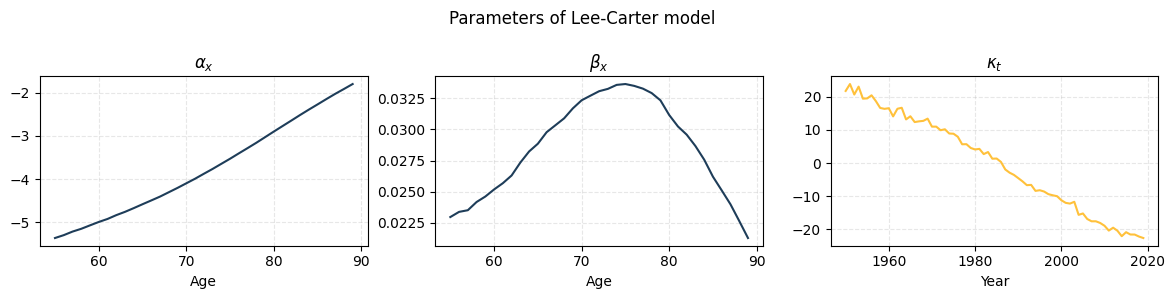

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

ax1.plot(x, a_LC, color=color_x)
ax1.set_xlabel("Age")
ax1.grid(ls="--", alpha=.3)
ax1.set_title(r"$\alpha_x$")

ax2.plot(x, b_LC, color=color_x)
ax2.set_xlabel("Age")
ax2.grid(ls="--", alpha=.3)
ax2.set_title(r"$\beta_x$")

ax3.plot(t, k_LC, color=color_t)
ax3.set_xlabel("Year")
ax3.grid(ls="--", alpha=.3)
ax3.set_title(r"$\kappa_t$")

fig.suptitle("Parameters of Lee-Carter model")
fig.tight_layout()

In [15]:
print("Convergence of LC model: {}".format(lc_model.convergence))

Convergence of LC model: True


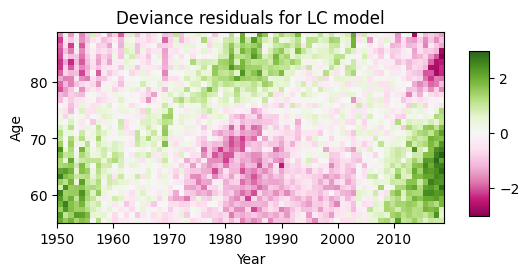

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))

plot = ax.imshow(
    X=lc_model.deviance_resid, 
    origin="lower", 
    cmap=cmap, 
    extent=[t_min , t_max, age_min , age_max], 
    vmin=vmin, 
    vmax=vmax
)
ax.set_ylabel("Age")
ax.set_xlabel("Year")

cax = plt.axes((0.95, 0.2, 0.04, 0.55))
fig.colorbar(mappable=plot, cax=cax)

ax.set_title("Deviance residuals for LC model");

## CBD model

The **Cairns-Blake-Dowd** model has the following predictor structure:

$$ \eta_{xt} = \kappa^{(1)}_{t} + (x - \bar{x})\kappa^{(2)}_{t}, $$

where $\bar{x}$ is the average age in the data.

The CBD model does not have identifiability issues.

In [17]:
from mortality_models.models import CBD

In [18]:
np.random.seed(seed)
kt1_init = np.random.random(t_max - t_min + 1)
kt2_init = np.random.random(t_max - t_min + 1)

In [19]:
cbd_model = CBD(
    data=data, 
    min_year=t_min, 
    max_year=t_max, 
    min_age=age_min, 
    max_age=age_max
)

In [20]:
k1_cbd, k2_cbd = cbd_model.fit(kt1_init, kt2_init)

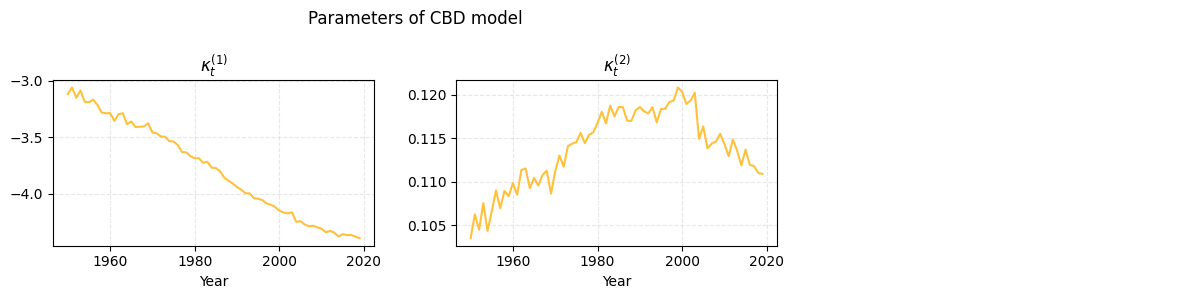

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

ax1.plot(t, k1_cbd, color=color_t)
ax1.set_xlabel("Year")
ax1.grid(ls="--", alpha=.3)
ax1.set_title(r"$\kappa^{(1)}_{t}$")

ax2.plot(t, k2_cbd, color=color_t)
ax2.set_xlabel("Year")
ax2.grid(ls="--", alpha=.3)
ax2.set_title(r"$\kappa^{(2)}_{t}$")

ax3.axis("off")

fig.suptitle("Parameters of CBD model", x=0.35)
fig.tight_layout()

In [22]:
print("Convergence of CBD model: {}".format(cbd_model.convergence))

Convergence of CBD model: True


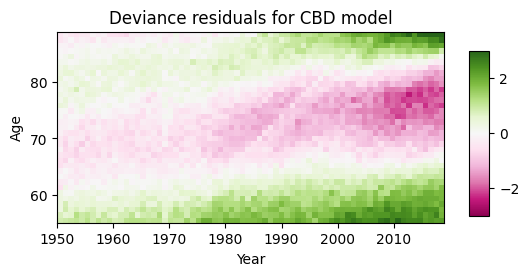

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))

plot = ax.imshow(
    X=cbd_model.deviance_resid, 
    origin="lower", 
    cmap=cmap, 
    extent=[t_min , t_max, age_min , age_max], 
    vmin=vmin, 
    vmax=vmax
)
ax.set_ylabel("Age")
ax.set_xlabel("Year")

cax = plt.axes((0.95, 0.2, 0.04, 0.55))
fig.colorbar(mappable=plot, cax=cax)

ax.set_title("Deviance residuals for CBD model");

## APC model

The **Age-Period-Cohort** model has the following predictor structure:

$$ \eta_{xt} = \alpha_{x} + \kappa_{t}^{(1)} + \gamma_{t-x}. $$

If $(\alpha_{x}, \kappa_{t}^{(1)}, \gamma_{t-x})$ is solution, then the two transformations 

$$(\alpha_{x}, \kappa_{t}^{(1)}, \gamma_{t-x}) \to (\alpha_{x} + \phi_{1} - \phi_{2}x, \kappa_{t}^{(1)} + \phi_{2}t, \gamma_{t-x} - \phi_{1} - \phi_{2}(t - x))$$

$$ (\alpha_{x}, \kappa_{t}^{(1)}, \gamma_{t-x}) \to (\alpha_{x} + c_{1}, \kappa_{t}^{(1)} - c_{1}, \gamma_{t-x})$$ 
leaves $\eta_{xt}$ unchanged.

Identifiability of the model is therefore ensured with the following added constraints:

$$ \sum_{t}{\kappa_{t}^{(1)}} = 0 \text{, }\quad \sum_{c=t_{1}-x_{k}}^{c=t_{n}-x_{1}}{\gamma_{c}} = 0 \text{, }\quad \sum_{c=t_{1}-x_{k}}^{c=t_{n}-x_{1}}{c\gamma_{c}} = 0 $$

which can be imposed by

1. Calculating $\phi_{1}$ and $\phi_{2}$ by regressing $\gamma_{t-x}$ on $t-x$, so that

$$ \gamma_{t-x} = \phi_{1} + \phi_{2}(t - x) + \epsilon_{t-x} \text{, }\qquad \epsilon_{t-x} \sim N(0, \sigma^{2}) \text{ i.i.d.}.$$

2. Calcuating $c_{1}$ on the new $\kappa_{t}^{(1)}$

$$ c_{1} = \frac{1}{n}\sum_{t}{\kappa_{t}^{(1)}}.$$

In [24]:
from mortality_models.models import APC

In [25]:
np.random.seed(seed)
ax_init = a_LC
kt_init = k1_cbd
gtx_init = np.random.random((t_max - age_min) - (t_min - age_max) + 1)

In [26]:
apc_model = APC(
    data=data, 
    min_year=t_min, 
    max_year=t_max, 
    min_age=age_min, 
    max_age=age_max
)

In [27]:
ax_apc, kt_apc, gtx_apc = apc_model.fit(ax_init, kt_init, gtx_init)

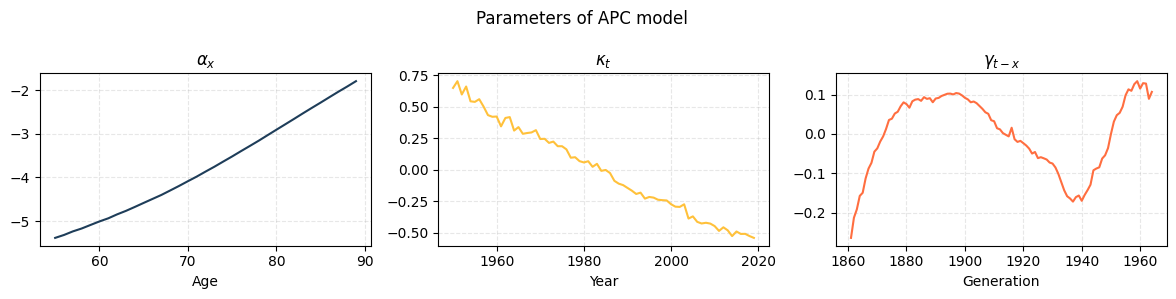

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

ax1.plot(x, ax_apc, color=color_x)
ax1.set_xlabel("Age")
ax1.grid(ls="--", alpha=.3)
ax1.set_title(r"$\alpha_x$")

ax2.plot(t, kt_apc, color=color_t)
ax2.set_xlabel("Year")
ax2.grid(ls="--", alpha=.3)
ax2.set_title(r"$\kappa_t$")

ax3.plot(g, gtx_apc, color=color_g)
ax3.set_xlabel("Generation")
ax3.grid(ls="--", alpha=.3)
ax3.set_title(r"$\gamma_{t-x}$")
fig.suptitle("Parameters of APC model")

fig.tight_layout()

In [29]:
print("Convergence of APC model: {}".format(apc_model.convergence))

Convergence of APC model: True


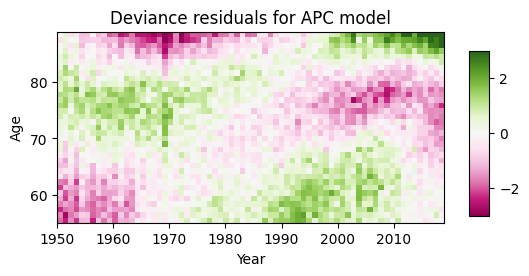

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))

plot = ax.imshow(
    X=apc_model.deviance_resid, 
    origin="lower", 
    cmap=cmap, 
    extent=[t_min , t_max, age_min , age_max], 
    vmin=vmin, 
    vmax=vmax
)
ax.set_ylabel("Age")
ax.set_xlabel("Year")

cax = plt.axes((0.95, 0.2, 0.04, 0.55))
fig.colorbar(mappable=plot, cax=cax)

ax.set_title("Deviance residuals for APC model");

## M6 model

The **M6** model has the following predictor structure:

$$ \eta_{xt} = \kappa^{(1)}_{t} + (x - \bar{x})\kappa^{(2)}_{t} + \gamma_{t - x}, $$

where $\bar{x}$ is the average age in the data.

If $(\kappa_{t}^{(1)}, \kappa_{t}^{(2)}, \gamma_{t-x})$ is solution, then the transformation

$$ (\kappa_{t}^{(1)}, \kappa_{t}^{(2)}, \gamma_{t-x}) \to (\kappa_{t}^{(1)} + \phi_{1} + \phi_{2}(t - \bar{x}), \kappa_{t}^{(2)} - \phi_{2}, \gamma_{t-x} - \phi_{1} - \phi_{2}(t - x)) $$

leaves $\eta_{xt}$ unchanged.

Identifiability of the model is therefore ensured with the following added constraints:

$$ \sum_{c=t_{1}-x_{k}}^{t_{n}-x_{1}}\gamma_{c} = 0 \text{, }\quad \sum_{c=t_{1}-x_{k}}^{t_{n}-x_{1}}c\gamma_{c} = 0, $$

which can be imposed by calculating $\phi_{1}$ and $\phi_{2}$ by regressing $\gamma_{t - x}$ on $(t - x)$ so that

$$ \gamma_{t-x} = \phi_{1} + \phi_{2}(t - x) + \epsilon_{t-x} \text{, }\qquad \epsilon_{t-x} \sim N(0, \sigma^{2}) \text{ i.i.d.}.$$

This ensures that the cohort effect fluctuates around zero and has no linear trend.

In [31]:
from mortality_models.models import M6

In [32]:
kt1_init = k1_cbd
kt2_init = k2_cbd
gtx_init = gtx_apc

In [33]:
m6_model = M6(
    data=data, 
    min_year=t_min, 
    max_year=t_max, 
    min_age=age_min, 
    max_age=age_max
)

In [34]:
kt1_m6, kt2_m6, gtx_m6 = m6_model.fit(kt1_init, kt2_init, gtx_init)

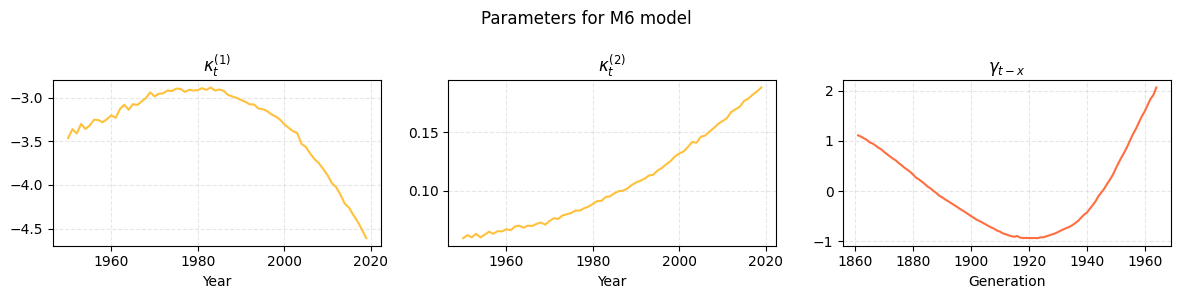

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

ax1.plot(t, kt1_m6, color=color_t)
ax1.set_xlabel("Year")
ax1.grid(ls="--", alpha=.3)
ax1.set_title(r"$\kappa^{(1)}_t$")

ax2.plot(t, kt2_m6, color=color_t)
ax2.set_xlabel("Year")
ax2.grid(ls="--", alpha=.3)
ax2.set_title(r"$\kappa^{(2)}_t$")

ax3.plot(g, gtx_m6, color=color_g)
ax3.set_xlabel("Generation")
ax3.grid(ls="--", alpha=.3)
ax3.set_title(r"$\gamma_{t-x}$")
fig.suptitle("Parameters for M6 model")

fig.tight_layout()

In [36]:
print("Convergence of M6 model: {}".format(m6_model.convergence))

Convergence of M6 model: True


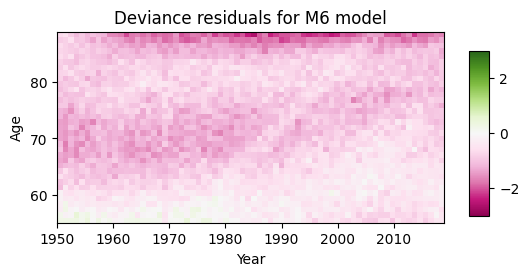

In [37]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))

plot = ax.imshow(
    X=m6_model.deviance_resid, 
    origin="lower", 
    cmap=cmap, 
    extent=[t_min , t_max, age_min , age_max], 
    vmin=vmin, 
    vmax=vmax
)
ax.set_ylabel("Age")
ax.set_xlabel("Year")

cax = plt.axes((0.95, 0.2, 0.04, 0.55))
fig.colorbar(mappable=plot, cax=cax)

ax.set_title("Deviance residuals for M6 model");

## M7 model

The **M7** model has the following predictor structure:

$$ \eta_{xt} = \kappa^{(1)}_{t} + (x - \bar{x})\kappa^{(2)}_{t} + ((x - \bar{x})^{2} - \hat{\sigma}_{x}^{2})\kappa^{(3)}_{t} + \gamma_{t - x}, $$

where $\bar{x}$ is the average age in the data and $\hat{\sigma}_{x}^{2}$ is the average value of $(x - \bar{x})^{2}$.

If $(\kappa_{t}^{(1)}, \kappa_{t}^{(2)}, \kappa_{t}^{(3)}, \gamma_{t-x})$ is solution, then the transformation

$$ (\kappa_{t}^{(1)}, \kappa_{t}^{(2)}, \kappa_{t}^{(3)}, \gamma_{t-x}) \to (\kappa_{t}^{(1)} + \phi_{1} + \phi_{2}(t - \bar{x}) + \phi_{3} \left((t - \bar{x})^{2} + \hat{\sigma}_{x}^{2} \right), \kappa_{t}^{(2)} - \phi_{2} - 2\phi_{3}(t - \bar{x}), \kappa_{t}^{(3)} + \phi_{3}, \gamma_{t-x} - \phi_{1} - \phi_{2}(t - x) - \phi_{3}(t - x)^{2}) $$

leaves $\eta_{xt}$ unchanged.

Identifiability of the model is therefore ensured with the following added constraints:

$$ \sum_{c=t_{1}-x_{k}}^{t_{n}-x_{1}}\gamma_{c} = 0 \text{, }\quad \sum_{c=t_{1}-x_{k}}^{t_{n}-x_{1}}c\gamma_{c} = 0 \text{, }\quad \sum_{c=t_{1}-x_{k}}^{t_{n}-x_{1}}c^{2}\gamma_{c} = 0$$

which can be imposed by calculating $\phi_{1}$, $\phi_{2}$ and $\phi_{3}$ by regressing $\gamma_{t-x}$ on $(t - x)$ and $(t - x)^{2}$, so that

$$ \gamma_{t-x} = \phi_{1} + \phi_{2}(t - x) + \phi_{3}(t - x)^{2} + \epsilon_{t-x} \text{, }\qquad \epsilon_{t-x} \sim N(0, \sigma^{2}) \text{ i.i.d.}.$$

This ensures that the cohort effect fluctuates around zero and has no linear or quadratic trend.

In [38]:
from mortality_models.models import M7

In [39]:
np.random.seed(seed)
kt1_init = kt1_m6
kt2_init = kt2_m6
kt3_init = np.random.random(t_max - t_min + 1)
gtx_init = gtx_m6

In [40]:
m7_model = M7(
    data=data, 
    min_year=t_min, 
    max_year=t_max, 
    min_age=age_min, 
    max_age=age_max
)

The convergence is extremely slow.

In [41]:
kt1_m7, kt2_m7, kt3_m7, gtx_m7 = m7_model.fit(kt1_init, kt2_init, kt3_init, gtx_init)

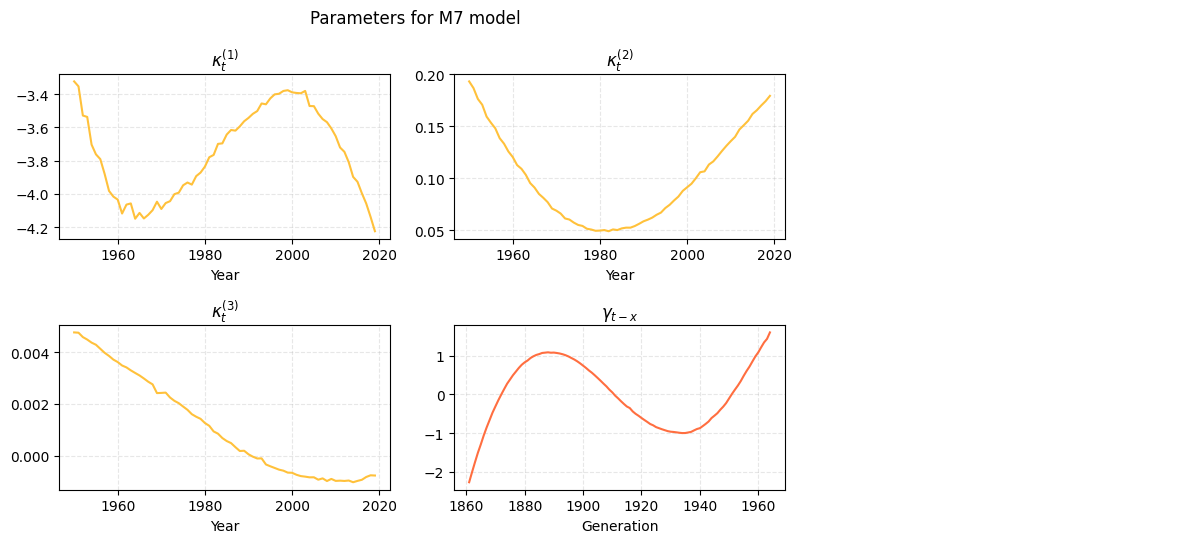

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 5.5))

ax[0, 0].plot(t, kt1_m7, color=color_t)
ax[0, 0].set_xlabel("Year")
ax[0, 0].grid(ls="--", alpha=.3)
ax[0, 0].set_title(r"$\kappa^{(1)}_t$")

ax[0, 1].plot(t, kt2_m7, color=color_t)
ax[0, 1].set_xlabel("Year")
ax[0, 1].grid(ls="--", alpha=.3)
ax[0, 1].set_title(r"$\kappa^{(2)}_t$")

ax[1, 0].plot(t, kt3_m7, color=color_t)
ax[1, 0].set_xlabel("Year")
ax[1, 0].grid(ls="--", alpha=.3)
ax[1, 0].set_title(r"$\kappa^{(3)}_t$")

ax[1, 1].plot(g, gtx_m7, color=color_g)
ax[1, 1].set_xlabel("Generation")
ax[1, 1].grid(ls="--", alpha=.3)
ax[1, 1].set_title(r"$\gamma_{t-x}$")

ax[0, 2].axis("off")
ax[1, 2].axis("off")

fig.suptitle("Parameters for M7 model", x=0.35)
fig.tight_layout()

In [43]:
print("Convergence of M7 model: {}".format(m7_model.convergence))

Convergence of M7 model: True


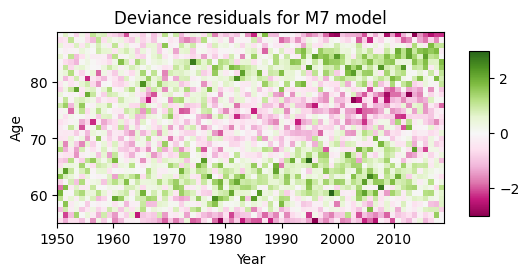

In [44]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))

plot = ax.imshow(
    X=m7_model.deviance_resid, 
    origin="lower", 
    cmap=cmap, 
    extent=[t_min , t_max, age_min , age_max], 
    vmin=vmin, 
    vmax=vmax
)
ax.set_ylabel("Age")
ax.set_xlabel("Year")

cax = plt.axes((0.95, 0.2, 0.04, 0.55))
fig.colorbar(mappable=plot, cax=cax)

ax.set_title("Deviance residuals for M7 model");

## M8 model

The **M8** model has the following predictor structure:

$$ \eta_{xt} = \kappa^{(1)}_{t} + (x - \bar{x})\kappa^{(2)}_{t} + (x_{c} - x)\gamma_{t - x}, $$

where $\bar{x}$ is the average age in the data and $x_{c}$ is a predefined constant.

If $(\kappa_{t}^{(1)}, \kappa_{t}^{(2)}, \gamma_{t-x})$ is solution, then the transformation

$$ (\kappa_{t}^{(1)}, \kappa_{t}^{(2)}, \gamma_{t-x}) \to (\kappa_{t}^{(1)} + c(x_{c} - \bar{x}), \kappa_{t}^{(2)} - c, \gamma_{t-x} - c) $$

leaves $\eta_{xt}$ unchanged.

Identifiability of the model is therefore ensured with the following added constraint:

$$ c = \frac{1}{g}\gamma_{c},$$

where $g$ is the number of generations.

In [45]:
from mortality_models.models import M8

In [46]:
x_c = 65

In [47]:
kt1_init = kt1_m6
kt2_init = kt2_m6
gtx_init = gtx_m6 / (x_c - np.mean(x))

In [48]:
m8_model = M8(
    data=data, 
    min_year=t_min, 
    max_year=t_max, 
    min_age=age_min, 
    max_age=age_max,
    x_c=x_c
)

In [49]:
kt1_m8, kt2_m8, gtx_m8 = m8_model.fit(kt1_init, kt2_init, gtx_init)

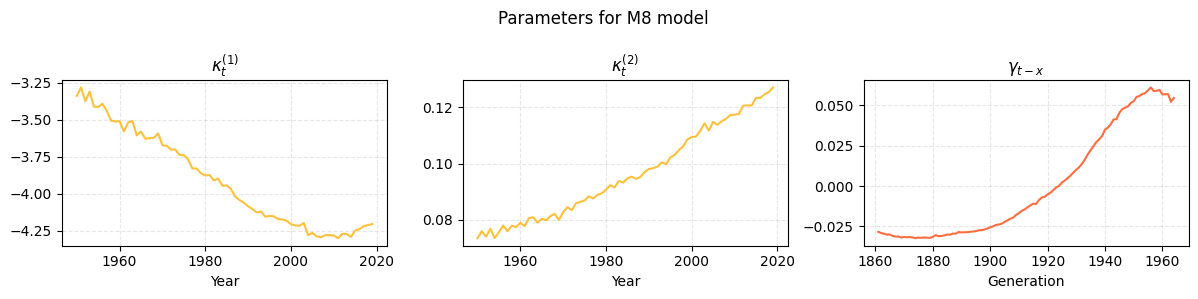

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

ax1.plot(t, kt1_m8, color=color_t)
ax1.set_xlabel("Year")
ax1.grid(ls="--", alpha=.3)
ax1.set_title(r"$\kappa^{(1)}_t$")

ax2.plot(t, kt2_m8, color=color_t)
ax2.set_xlabel("Year")
ax2.grid(ls="--", alpha=.3)
ax2.set_title(r"$\kappa^{(2)}_t$")

ax3.plot(g, gtx_m8, color=color_g)
ax3.set_xlabel("Generation")
ax3.grid(ls="--", alpha=.3)
ax3.set_title(r"$\gamma_{t-x}$")
fig.suptitle("Parameters for M8 model")

fig.tight_layout()

In [51]:
print("Convergence of M8 model: {}".format(m8_model.convergence))

Convergence of M8 model: True


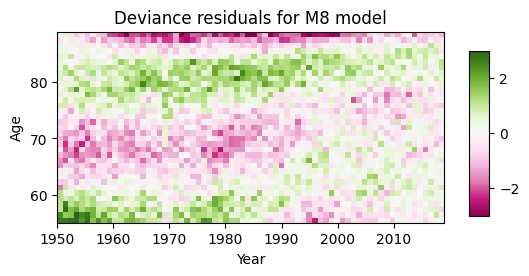

In [52]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))

plot = ax.imshow(
    X=m8_model.deviance_resid, 
    origin="lower", 
    cmap=cmap, 
    extent=[t_min , t_max, age_min , age_max], 
    vmin=vmin, 
    vmax=vmax
)
ax.set_ylabel("Age")
ax.set_xlabel("Year")

cax = plt.axes((0.95, 0.2, 0.04, 0.55))
fig.colorbar(mappable=plot, cax=cax)

ax.set_title("Deviance residuals for M8 model");

## Comparisons

In [53]:
from sklearn.metrics import (
    mean_squared_error,
    median_absolute_error,
    explained_variance_score,
    r2_score,
    mean_absolute_percentage_error,
    mean_poisson_deviance
)

In [54]:
models = {
    "LC": lc_model,
    "CBD": cbd_model,
    "APC": apc_model,
    "M6": m6_model,
    "M7": m7_model,
    "M8": m8_model
}

In [55]:
metrics = {
    "MSE": [mean_squared_error, "min", 1],
    "MAE": [median_absolute_error, "min", 1],
    "MAPE (%)": [mean_absolute_percentage_error, "min", 100],
    "Explained variance (%)": [explained_variance_score, "max", 100],
    "r2 (%)": [r2_score, "max", 100],
    "Deviance": [mean_poisson_deviance, "min", 1]
}

In [56]:
comparison = pd.DataFrame()
for m in metrics:
    for mod in models:
        y_true = models[mod].data_predict["DX"]
        y_pred = models[mod].data_predict["DX_PRED"]
        weight = models[mod].data_predict["EX"]
        base = metrics[m][2]
        comparison.loc[mod, m] = metrics[m][0](y_true=y_true, y_pred=y_pred, sample_weight=weight) * base

In [57]:
subset_min = [col for col in metrics if metrics[col][1] == "min"]
subset_max = [col for col in metrics if metrics[col][1] == "max"]

In [58]:
comparison.style.highlight_max(subset=subset_max, color="lightgreen").highlight_min(subset=subset_min, color="lightgreen").highlight_max(subset=subset_min, color="lightcoral").highlight_min(subset=subset_max, color="lightcoral")

,MSE,MAE,MAPE (%),Explained variance (%),r2 (%),Deviance
LC,28814.617427,106.479254,4.050767,99.692059,99.691882,7.459320
CBD,196753.260208,293.982236,11.187156,97.900733,97.896097,56.827271
APC,40037.354314,105.570010,3.906644,99.571963,99.571876,7.929744
M6,171482.975312,292.020126,7.532864,99.342584,98.166315,27.287666
M7,7051.607615,49.067679,1.772845,99.924598,99.924596,1.541197
M8,16553.889957,68.554552,2.436133,99.822992,99.822988,3.287744


M7 model gives the best results, which is logical since it is the most parameterized model, and CBD model, which does not take into acount age, gives the worst results.